# Import required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

c:\programdata\anaconda3\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# Define parameters for data loading here:

## Fib using 1 std

In [2]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647


# analysis done
num_of_ch = 4

# Replace protein/dna label name in the "xxx" below for the indicated channel index (make sure the order is correct)
# For example: ch_dict = {"dna":1,"rpa/rpa2":2,"mdc1":3,"pol2S5":4} if rpa/rpa2 was used for ch488
# Make sure the label name is the same as the factor/dna key used in the line below
ch_dict = {"dna":1,"Mdc1":2,"Fibirill":3,"Pol2Se":4}

# If use mdc1 as the factor for region segementation
# If use dna/dapi as the key channel for nucleus segmentation
factor_key =  "Mdc1"
dna_key = 'Pol2Se'  # temporary fix since DNA is not good
nucleoli_key="Fibirill"
pol2_key = 'Pol2Se'



# Replace the data directory in the ""; * is the final path level where images are located
# For example: data_save_folder = r"F:\XXX\AAA\BBB\*"
data_save_folder = r"D:\Analyzed_CellBio\Stam\cov1_Mdc1-488 Fibrill-568 PolS5-647\*"

data_files = [file for file in glob.glob(data_save_folder) if 'score.xlsx' in file]


In [3]:
data_files

['D:\\Analyzed_CellBio\\Stam\\cov1_Mdc1-488 Fibrill-568 PolS5-647\\Fibrill_PolS5_exp0_score.xlsx',
 'D:\\Analyzed_CellBio\\Stam\\cov1_Mdc1-488 Fibrill-568 PolS5-647\\Fibrill_PolS5_exp1_score.xlsx',
 'D:\\Analyzed_CellBio\\Stam\\cov1_Mdc1-488 Fibrill-568 PolS5-647\\Fibrill_PolS5_exp2_score.xlsx']

In [11]:
all_measurement_df = pd.DataFrame()


for file in data_files:
    
    _each_exp_df = pd.read_excel(file)
    _each_exp_df.insert(0,'exp_name', file.split('\\')[-1].split('_score')[0])
    all_measurement_df = pd.concat([all_measurement_df,_each_exp_df])

In [14]:
all_measurement_df


,exp_name,fov id,cell id,mdc positive chr,assigned_fib_global_otsu,fib_in_po2_global_otsu,assigned_fib_cell_otsu,fib_in_po2_cell_otsu,assigned_fib_p10,fib_in_po2_p10,...,fib_in_po2_p40,assigned_fib_p50,fib_in_po2_p50,score_global_otsu,score_cell_otsu,score_p10,score_p20,score_p30,score_p40,score_p50
0,Fibrill_PolS5_exp0,1,1,No,0.100633,0.723705,0.004802,0.916667,0.050207,0.782313,...,0.684840,0.123772,0.638514,0.072829,0.004402,0.039278,0.058430,0.071217,0.076990,0.079030
1,Fibrill_PolS5_exp0,1,2,No,0.075150,0.540506,0.000528,0.428571,0.028247,0.545918,...,0.552357,0.126012,0.539157,0.040619,0.000226,0.015421,0.027036,0.039853,0.054098,0.067940
2,Fibrill_PolS5_exp0,1,3,No,0.094486,0.585409,0.000000,NaN,0.040494,0.705000,...,0.519515,0.136129,0.459748,0.055313,NaN,0.028548,0.047118,0.054994,0.057591,0.062585
3,Fibrill_PolS5_exp0,1,4,No,0.120582,0.427439,0.002013,0.818182,0.055481,0.504065,...,0.380864,0.161745,0.334722,0.051541,0.001647,0.027966,0.042164,0.050911,0.052571,0.054140
4,Fibrill_PolS5_exp0,1,5,No,0.084945,0.185941,0.000000,NaN,0.027279,0.175556,...,0.192614,0.157804,0.199913,0.015795,NaN,0.004789,0.009749,0.015556,0.022547,0.031547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,Fibrill_PolS5_exp2,20,15,Yes,0.261983,0.363532,0.157025,0.434783,0.174380,0.398866,...,0.244514,0.447934,0.213891,0.095239,0.068272,0.069554,0.095063,0.086088,0.094572,0.095809
293,Fibrill_PolS5_exp2,20,16,No,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
294,Fibrill_PolS5_exp2,20,17,No,0.991304,0.406417,0.973913,0.682927,0.980435,0.597351,...,0.211013,0.991304,0.174780,0.402883,0.665111,0.585664,0.384057,0.275295,0.209179,0.173260
295,Fibrill_PolS5_exp2,20,18,Yes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
all_measurement_df.groupby(by=['mdc positive chr']).mean()

,fov id,cell id,assigned_fib_global_otsu,fib_in_po2_global_otsu,assigned_fib_cell_otsu,fib_in_po2_cell_otsu,assigned_fib_p10,fib_in_po2_p10,assigned_fib_p20,fib_in_po2_p20,...,fib_in_po2_p40,assigned_fib_p50,fib_in_po2_p50,score_global_otsu,score_cell_otsu,score_p10,score_p20,score_p30,score_p40,score_p50
mdc positive chr,,,,,,,,,,,,,,,,,,,,,
No,11.778559,6.984183,0.342025,0.499287,0.221810,0.628341,0.263552,0.585111,0.336994,0.504588,...,0.381726,0.464301,0.329852,0.172021,0.150793,0.161493,0.171509,0.166713,0.156243,0.144808
Yes,13.346821,6.473988,0.323549,0.483495,0.218238,0.615376,0.252977,0.576614,0.320382,0.493094,...,0.370442,0.442725,0.321779,0.155785,0.146772,0.156266,0.157003,0.150905,0.142529,0.133465


## Fib using 3std

In [5]:

# Replace the data directory in the ""; * is the final path level where images are located
# For example: data_save_folder = r"F:\XXX\AAA\BBB\*"
data_save_folder = r"D:\Analyzed_CellBio\Stam\cov1_Mdc1-488 Fibrill-568 PolS5-647\*"

data_files = [file for file in glob.glob(data_save_folder) if 'Fib_3std_score.xlsx' in file]
data_files

['D:\\Analyzed_CellBio\\Stam\\cov1_Mdc1-488 Fibrill-568 PolS5-647\\Fibrill_PolS5_exp0_Fib_3std_score.xlsx',
 'D:\\Analyzed_CellBio\\Stam\\cov1_Mdc1-488 Fibrill-568 PolS5-647\\Fibrill_PolS5_exp1_Fib_3std_score.xlsx',
 'D:\\Analyzed_CellBio\\Stam\\cov1_Mdc1-488 Fibrill-568 PolS5-647\\Fibrill_PolS5_exp2_Fib_3std_score.xlsx']

In [16]:
all_measurement_df_3td = pd.DataFrame()


for file in data_files:
    
    _each_exp_df = pd.read_excel(file)
    _each_exp_df.insert(0,'exp_name', file.split('\\')[-1].split('_score')[0])
    all_measurement_df_3td = pd.concat([all_measurement_df_3td,_each_exp_df])
    
    
all_measurement_df_3td.groupby(by=['mdc positive chr']).mean()

,fov id,cell id,assigned_fib_global_otsu,fib_in_po2_global_otsu,assigned_fib_cell_otsu,fib_in_po2_cell_otsu,assigned_fib_p10,fib_in_po2_p10,assigned_fib_p20,fib_in_po2_p20,...,fib_in_po2_p40,assigned_fib_p50,fib_in_po2_p50,score_global_otsu,score_cell_otsu,score_p10,score_p20,score_p30,score_p40,score_p50
mdc positive chr,,,,,,,,,,,,,,,,,,,,,
No,12.118040,7.109131,0.623082,0.244565,0.419307,0.334516,0.495532,0.300507,0.614962,0.245223,...,0.172326,0.777997,0.144053,0.156416,0.154154,0.160088,0.156930,0.144114,0.128039,0.111989
Yes,12.960784,6.359477,0.598673,0.251428,0.418027,0.341591,0.487990,0.314138,0.592314,0.255493,...,0.182750,0.753233,0.152294,0.151189,0.156121,0.162676,0.153046,0.140492,0.126910,0.112284


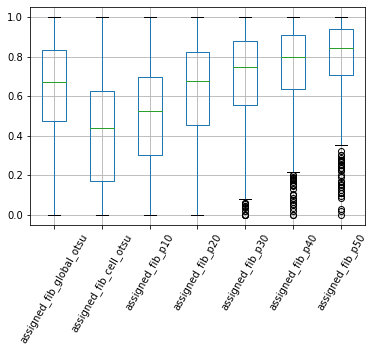

In [15]:
# How much Fib get assigned into Pol2-negative area
# Control nulcei
plt.figure();
from matplotlib.pyplot import figure

#figure(figsize=(6, 4), dpi=180)

all_measurement_df_3td[all_measurement_df_3td['mdc positive chr']=='No'].boxplot(column=["assigned_fib_global_otsu", "assigned_fib_cell_otsu", 
                                         "assigned_fib_p10", "assigned_fib_p20", 
                                         "assigned_fib_p30","assigned_fib_p40",
                                        "assigned_fib_p50"],rot=60)

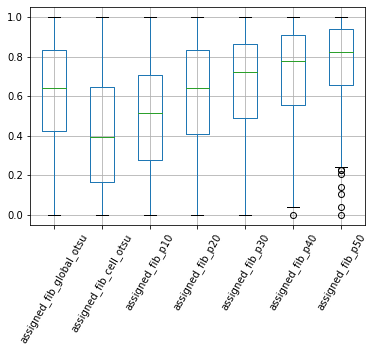

In [14]:
# How much Fib get assigned into Pol2-negative area
# Mdc-positive nulcei

plt.figure();
from matplotlib.pyplot import figure

#figure(figsize=(6, 4), dpi=180)

all_measurement_df_3td[all_measurement_df_3td['mdc positive chr']=='Yes'].boxplot(column=["assigned_fib_global_otsu", "assigned_fib_cell_otsu", 
                                         "assigned_fib_p10", "assigned_fib_p20", 
                                         "assigned_fib_p30","assigned_fib_p40",
                                        "assigned_fib_p50"],rot=60)

c:\programdata\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


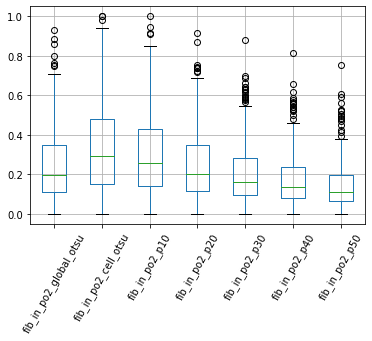

In [13]:
# How much of the Pol2-negative area is occupied by Fib
# Control nulcei

plt.figure();
from matplotlib.pyplot import figure

#figure(figsize=(6, 4), dpi=180)

all_measurement_df_3td[all_measurement_df_3td['mdc positive chr']=='No'].boxplot(column=["fib_in_po2_global_otsu", "fib_in_po2_cell_otsu", 
                                         "fib_in_po2_p10", "fib_in_po2_p20", 
                                         "fib_in_po2_p30","fib_in_po2_p40",
                                        "fib_in_po2_p50"],rot=60)

c:\programdata\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


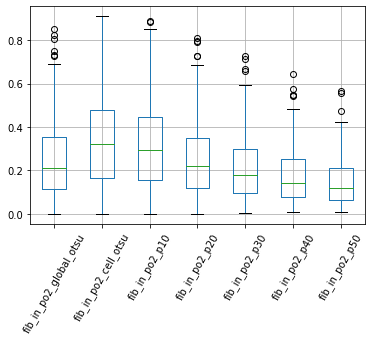

In [12]:
# How much of the Pol2-negative area is occupied by Fib
# Mdc-positive nulcei

plt.figure();
from matplotlib.pyplot import figure

#figure(figsize=(6, 4), dpi=180)

all_measurement_df_3td[all_measurement_df_3td['mdc positive chr']=='Yes'].boxplot(column=["fib_in_po2_global_otsu", "fib_in_po2_cell_otsu", 
                                         "fib_in_po2_p10", "fib_in_po2_p20", 
                                         "fib_in_po2_p30","fib_in_po2_p40",
                                        "fib_in_po2_p50"],rot=60)